## Imports

In [1]:
import copy
import glob
import importlib
import math
import os
import random
import shutil
import sys
from math import degrees, pi, radians
from os.path import *

import keras
import mahotas.features as mah
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk
import skimage.feature as skf
from skimage.morphology import ball

import cnn_builder as cbuild
import config
import lipiodol_methods as lm
import niftiutils.helper_fxns as hf
import niftiutils.liver_metrics as lmet
import niftiutils.masks as masks
import niftiutils.registration as reg
import niftiutils.transforms as tr
from config import Config
import skimage.morphology

%matplotlib inline

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
importlib.reload(config)
C = config.Config()

img_dir = "D:\\Lipiodol\\Images all"
seg_dir = "D:\\Lipiodol\\Images extracted and segmentations"
target_dir = "D:\\Lipiodol\\Data"

# Data Handling

In [200]:
df = pd.read_excel("D:\Lipiodol\pk-study_spreadsheet.xlsx", sheetname="pat_info")
df=df.dropna(subset=["Subject ID", "CT24 Accession #"])

In [374]:
for fn in glob.glob(join(target_dir, "*")):
    os.rename(fn, join(dirname(fn), "BM-"+basename(fn)))

In [ ]:
for fn in glob.glob(join(pk_target_dir, "*")):
    accnum = df.loc[df["Subject ID"]==basename(fn),"CT24 Accession #"].values[0]
    if not exists(join(pk_src_dir, accnum)):
        print(basename(fn), accnum)
    else:
        shutil.copytree(join(pk_src_dir, accnum), join(fn, "CT24h"))
        print(join(fn, "CT24h"))

### Corrupt data

In [7]:
big_path = r"C:\Users\Clinton\Desktop\MRI Abdomen W WO Contrast"
header = hf.dcm_load_header(big_path)

In [8]:
dcm_path = [r"C:\Users\Clinton\Desktop\New folder",
        r"C:\Users\Clinton\Desktop\New folder2",
        r"C:\Users\Clinton\Desktop\New folder3",
        r"C:\Users\Clinton\Desktop\New folder4"]

In [9]:
for i in range(4):
    os.makedirs(dcm_path[i])

In [10]:
acq_t = [124326.42, 124404.46, 124446.79, 124633.32]

In [11]:
for ix,fn in enumerate(glob.glob(join(big_path, "*"))):
    h = hf.dcm_load_header(fn)
    for i in range(4):
        if abs(float(h[0].AcquisitionTime) - acq_t[i]) < .02:
            shutil.copy(fn, join(dcm_path[i], basename(fn)))

for fn in glob.glob(join(dcm_path, "*")):
    if int(header[int(fn[-7:-4])-1].TemporalPositionIdentifier) == 2:
        shutil.move(fn, join(dcm_path2, basename(fn)))
    elif int(header[int(fn[-7:-4])-1].TemporalPositionIdentifier) == 3:
        shutil.move(fn, join(dcm_path3, basename(fn)))
    elif int(header[int(fn[-7:-4])-1].TemporalPositionIdentifier) == 4:
        shutil.move(fn, join(dcm_path4, basename(fn)))

In [ ]:
dim = 1
base = float(header[0].SliceLocation)
for x,h in enumerate(header[1:]):
    dz = float(h.SliceLocation) - base
    print(dz)
    base = float(h.SliceLocation)

In [412]:
fn = ["t1-pre.nii", "t1-art.nii", "t1-pv.nii", "t1-equ.nii"]

In [418]:
for i in range(2,3):
    a,dims = hf.dcm_load(dcm_path[i], True, True)
    save_path = join(dirname(dcm_path[i]), "07", fn[i])
    hf.save_nii(a, save_path, dims)

In [120]:
dcm_path = join(target_dir, patient_id, "CT24h")
fns = glob.glob(join(dcm_path, "*"))
z1 = float(hf.dcm_load_header(fns[0])[0].ImagePositionPatient[-1])
z2 = float(hf.dcm_load_header(fns[1])[0].ImagePositionPatient[-1])
dz = z1-z2
for ix,fn in enumerate(fns[1:]):
    h = hf.dcm_load_header(fn)
    z2 = float(h[0].ImagePositionPatient[-1])
    if abs(z1-z2 - dz) > 1e-3:
        print(fn, z1-z2)
        break
    z1 = z2

D:\Lipiodol\Data\34\CT24h\IMG-0001-00010.dcm 6.0


## MRI loading

In [156]:
target_dir = "D:\\Lipiodol\\Data"
patient_id = "BM-25".upper()
importlib.reload(lm)
paths = lm.get_paths(patient_id, target_dir, check_valid=False)

mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
mribl_art_path, mribl_pre_path, mribl_sub_path, \
mribl_tumor_mask_path, mribl_liver_mask_path, \
mribl_enh_mask_path, mribl_nec_mask_path, \
mri30d_art_path, mri30d_pre_path, \
mri30d_tumor_mask_path, mri30d_liver_mask_path, \
mri30d_enh_mask_path, mri30d_nec_mask_path, \
ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
midlip_mask_path, ball_midlip_mask_path, \
highlip_mask_path, ball_highlip_mask_path = paths

In [82]:
modality = "MRI-BL"

dcm_paths = [x for x in glob.glob(join(target_dir, patient_id, modality,"*")) if x.find('.')==-1]
for dcm_path in dcm_paths:
    if not exists(splitext(dcm_path)[0] + ".nii.gz"):
        try:
            save_path = splitext(dcm_path)[0] + ".nii.gz"
            img, dims = hf.dcm_load(dcm_path, True, True)
            hf.save_nii(img, save_path, dims)
        except:
            print(dcm_path)

In [179]:
paths = [x for x in glob.glob(join(target_dir, patient_id, modality,"*.nii.gz")) if '20s' in x or 'Ph1-Ax' in x]
if modality == "MRI-30d":
    save_path = mri30d_art_path
elif modality == "MRI-BL":
    save_path = mribl_art_path
if len(paths)==1:
    os.rename(paths[0], save_path)

In [180]:
paths = [x for x in glob.glob(join(target_dir, patient_id, modality,"*.nii.gz")) \
         if ('pre' in x.lower() and 'post' not in x.lower()) or basename(x).startswith('Ax LAVA-XV')]
if modality == "MRI-30d":
    save_path = mri30d_pre_path
elif modality == "MRI-BL":
    save_path = mribl_pre_path
if len(paths)==1:
    os.rename(paths[0], save_path)

In [ ]:
art, D = hf.nii_load(mribl_art_path)
sub = art - hf.nii_load(mribl_pre_path)[0]
hf.save_nii(sub, mribl_sub_path, D)

## Make liver mask

In [6]:
model = keras.models.load_model(join(config.Config().model_dir, "mri_liver.hdf5"))

In [185]:
lm.seg_liver_mri_from_path(mri30d_art_path, mri30d_liver_mask_path, model, mri30d_tumor_mask_path)

In [227]:
model = keras.models.load_model(join(config.Config().model_dir, "ct_liver.hdf5"))

In [ ]:
#importlib.reload(lm)
lm.seg_liver_ct(ct24_path, ct24_liver_mask_path, model, ct24_tumor_mask_path)

## Segment Lipiodol

In [229]:
importlib.reload(lm)
#for patient_id in ["BM-05", "BM-07", "BM-07"]
patient_id = "BM-07"
paths = lm.get_paths(patient_id, target_dir)

mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
mribl_art_path, mribl_pre_path, mribl_sub_path, \
mribl_tumor_mask_path, mribl_liver_mask_path, \
mribl_enh_mask_path, mribl_nec_mask_path, \
mri30d_art_path, mri30d_pre_path, \
mri30d_tumor_mask_path, mri30d_liver_mask_path, \
mri30d_enh_mask_path, mri30d_nec_mask_path, \
ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
midlip_mask_path, ball_midlip_mask_path, \
highlip_mask_path, ball_highlip_mask_path = paths
ctbl_path = join(target_dir, patient_id, "nii_files", "ctbl.nii.gz")
#ctbl_tumor_mask_path = (glob.glob(join(mask_dir, "tumor bl ct*.ids")) + glob.glob(join(mask_dir, "tumor ct bl*.ids")))[0][:-4]
ctbl_liver_mask_path = join(mask_dir, "wholeliver_BLCT")

In [231]:
ct_img, ct_dims = hf.dcm_load(join(target_dir, patient_id, "CTBL"), True, True)
hf.save_nii(ct_img, ctbl_path, ct_dims)

In [232]:
lm.seg_liver_ct(ctbl_path, ctbl_liver_mask_path, model)

In [222]:
masks.restrict_mask_to_largest(ctbl_tumor_mask_path, img_path=ctbl_path)

In [ ]:
A=masks.draw_mask(ctbl_liver_mask_path, ctbl_path, [0,200])

In [253]:
A = skimage.morphology.grey.erosion(A)

In [254]:
np.percentile(A[A>0], 99.5)

84.0

In [ ]:
masks.draw_mask(ct24_tumor_mask_path, ct24_path, [0,300]);

In [168]:
ct_img, ct_dims = hf.dcm_load(join(target_dir, patient_id, "CT24h"), True, True)
hf.save_nii(ct_img, ct24_path, ct_dims)
lm.seg_lipiodol(patient_id, target_dir)

## Split masks of multiple tumors (run once)

In [98]:
importlib.reload(lm)
lm.check_multi_tumors(patient_id, target_dir)
lm.restrict_masks(patient_id, target_dir)

In [ ]:
#Identify multi-tumor patients
for fn in glob.glob(join(target_dir,"*")):
    patient_id = basename(fn)
    lm.restrict_masks(patient_id, target_dir)

importlib.reload(masks)
for fn in glob.glob(join(target_dir,"*","masks", "ZZbackup*")):
    os.rename(fn, join(dirname(fn), basename(fn)[8:]))

importlib.reload(masks)

for fn in glob.glob(join(target_dir,"*"))[3:]:
    patient_id = basename(fn)
    paths = lm.get_paths(patient_id, target_dir)

    mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
    mribl_art_path, mribl_pre_path, mribl_sub_path, \
    mribl_tumor_mask_path, mribl_liver_mask_path, \
    mribl_enh_mask_path, mribl_nec_mask_path, \
    mri30d_art_path, mri30d_pre_path, \
    mri30d_tumor_mask_path, mri30d_liver_mask_path, \
    mri30d_enh_mask_path, mri30d_nec_mask_path, \
    ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
    ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
    midlip_mask_path, ball_midlip_mask_path, \
    highlip_mask_path, ball_highlip_mask_path = paths
    
    print(patient_id)
    #lm.seg_lipiodol(ct24_path, mask_dir, ct24_liver_mask_path)
    masks.intersection(mribl_enh_mask_path, mribl_tumor_mask_path, img_path=mribl_art_path)
    masks.intersection(mribl_nec_mask_path, mribl_tumor_mask_path, img_path=mribl_art_path)
    masks.intersection(mri30d_enh_mask_path, mri30d_tumor_mask_path, img_path=mri30d_art_path)
    masks.intersection(mri30d_nec_mask_path, mri30d_tumor_mask_path, img_path=mri30d_art_path)

patient_id = basename("BM-30")
paths = lm.get_paths(patient_id, target_dir)

mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
mribl_art_path, mribl_pre_path, mribl_sub_path, \
mribl_tumor_mask_path, mribl_liver_mask_path, \
mribl_enh_mask_path, mribl_nec_mask_path, \
mri30d_art_path, mri30d_pre_path, \
mri30d_tumor_mask_path, mri30d_liver_mask_path, \
mri30d_enh_mask_path, mri30d_nec_mask_path, \
ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
midlip_mask_path, ball_midlip_mask_path, \
highlip_mask_path, ball_highlip_mask_path = paths

img,_ = hf.nii_load(mribl_art_path)
mask,_ = masks.get_mask(mribl_tumor_mask_path, img_path=mribl_art_path)

hf.draw_slices(hf.crop_nonzero(mask*img)[0])

## qEASL

In [7]:
importlib.reload(lmet)

In [ ]:
threshold = 6.9700
lmet.seg_tumor_from_threshold(mribl_art_path, mribl_pre_path,
                              threshold, mribl_tumor_mask_path,
                              mribl_enh_mask_path, mribl_nec_mask_path)
masks.draw_mask(mribl_enh_mask_path, mribl_art_path);

In [ ]:
masks.draw_mask(mribl_nec_mask_path, mribl_art_path);

In [ ]:
threshold = 32.788
lmet.seg_tumor_from_threshold(mri30d_art_path, mri30d_pre_path,
                              threshold, mri30d_tumor_mask_path,
                              mri30d_enh_mask_path, mri30d_nec_mask_path)
masks.draw_mask(mri30d_enh_mask_path, mri30d_art_path);

In [ ]:
masks.draw_mask(mri30d_nec_mask_path, mri30d_art_path);

In [149]:
target_dir = "D:\\Lipiodol\\Data"
patient_id = "Bm-16b".upper()
importlib.reload(lm)
paths = lm.get_paths(patient_id, target_dir, check_valid=False)

mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
mribl_art_path, mribl_pre_path, mribl_sub_path, \
mribl_tumor_mask_path, mribl_liver_mask_path, \
mribl_enh_mask_path, mribl_nec_mask_path, \
mri30d_art_path, mri30d_pre_path, \
mri30d_tumor_mask_path, mri30d_liver_mask_path, \
mri30d_enh_mask_path, mri30d_nec_mask_path, \
ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
midlip_mask_path, ball_midlip_mask_path, \
highlip_mask_path, ball_highlip_mask_path = paths

In [ ]:
ART=masks.crop_img_to_mask_vicinity(mribl_art_path, mribl_tumor_mask_path,.1)
PRE=masks.crop_img_to_mask_vicinity(mribl_pre_path, mribl_tumor_mask_path,.1)
hf.draw_slices(ART-PRE)

In [ ]:
# plot subtraction
ART=masks.crop_img_to_mask_vicinity(mri30d_art_path, mri30d_tumor_mask_path,.1)
PRE=masks.crop_img_to_mask_vicinity(mri30d_pre_path, mri30d_tumor_mask_path,.1)
hf.draw_slices(ART-PRE)

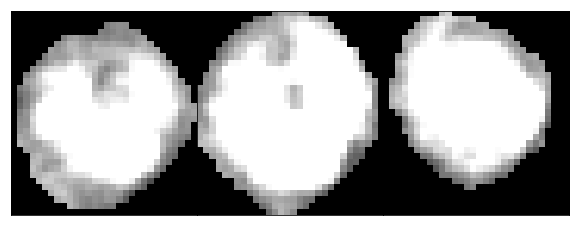

In [157]:
importlib.reload(masks)
I=masks.draw_mask(ct24_tumor_mask_path, ct24_path, [0,300])

In [24]:
#qEASLy
importlib.reload(lmet)
threshold1=lmet.segment_tumor_from_paths(mribl_art_path, mribl_pre_path,
                              mribl_liver_mask_path, mribl_tumor_mask_path,
                              mribl_enh_mask_path, mribl_nec_mask_path)
threshold2=lmet.segment_tumor_from_paths(mri30d_art_path, mri30d_pre_path,
                              mri30d_liver_mask_path, mri30d_tumor_mask_path,
                              mri30d_enh_mask_path, mri30d_nec_mask_path)

## Non-rigid reg

In [ ]:
importlib.reload(lm)
lm.spherize(patient_id, target_dir)

In [152]:
[basename(fn) for fn in glob.glob(join(target_dir,"*"))].index("BM-23")

17

In [ ]:
importlib.reload(lm)
for fn in glob.glob(join(target_dir,"*"))[17:]:
    patient_id = basename(fn)
    print(patient_id)
    lm.spherize(patient_id, target_dir)

# Extra

## Compose with rotation

In [191]:
mribl_liver_mask_path = join(target_dir, patient_id, "liver bl final.ids")
ct24_liver_mask_path = glob.glob(join(target_dir, patient_id, "wholeliver_24hCT*.ids"))[0]

In [ ]:
mribl_ct24_xform, ct24_tumor, mribl_tumor, mribl_ct24_crops = full_reg_masks(ct24_tumor_mask_path, ct24_path, mribl_tumor_mask_path, mribl_art_path)

In [ ]:
# BL MRI to 24h CT
vec_field = lm.reg_masks(ct_tumor_mask_path, blmri_tumor_mask_path)

In [ ]:
mribl_enh_mask = reg.apply_field(vec_field)

In [ ]:
ct24_lip = lm.seg_lipiodol()

In [ ]:
reg.reg_sitk(ct24_lip, vec_field)

In [114]:
mri_dcm_paths = [x for x in glob.glob(join(target_dir, '*', 'MRI-BL', '*20s*')) if '.nii' not in x]
mri_dcm_paths

In [ ]:
path_dict = {}
patient_id = '04'
for path in glob.glob(join(target_dir, patient_id, "MRI-BL","*","*")):
    header = hf.dcm_load_header(path)
    if len(header) > 0:
        series_descript = header[0][('0008', '103e')].value
        path_dict[path] = series_descript
        series_descript = series_descript.replace("/","-")
        os.rename(path, join(target_dir,patient_id, "MRI-BL", series_descript))

In [499]:
for path in glob.glob(join(target_dir, "*", "masks","*final*")):
    if not exists(path.replace(" final", "")):
        os.rename(path, path.replace(" final", ""))

## Target/non-target seg

In [ ]:
# Lipiodol target vs non-target masks
info = {}
for seg in glob.glob(join(target_dir,"*","wholeliver_24hCT*.ids")):
    if dirname(seg) in info.keys():
        (ct_img, ct_dims, mask) = info[dirname(seg)]
    else:
        ct_img, ct_dims = hf.dcm_load(join(dirname(seg), "CT24h"), True, True)
        mask, _ = masks.get_mask(seg, ct_dims, ct_img.shape)
        
    lm.seg_target_lipiodol((mask > 0) * ct_img, dirname(seg), ct_dims)
    info[dirname(seg)] = (ct_img, ct_dims, mask)
    #break